## IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd ; import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

## DISABLING THE SETTING WITH COPY WARNING

In [2]:
pd.options.mode.chained_assignment = None

## IMPORTING DATA

In [3]:
def importData(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

faces = importData('../preprocessing/data/facesDataClean.csv')
faces = faces[faces['age'] > 15]
faces = faces[faces['age'] < 70]

## PREPARING THE PIXELS COLUMN FOR THE NEURAL NETWORK IN THE IMAGES

In [4]:
def formatPixels(pixels: str) -> np.array:

    pixelsArray = np.array(pixels.split(), 'float64')
    pixelsArrayReshaped = pixelsArray.reshape(48, 48)

    return pixelsArrayReshaped

faces['pixels'] = faces['pixels'].apply(formatPixels)

## PERFORMING THE X-Y TRAIN-TEST SPLIT

In [5]:
def split(dataframe, pixels, age):

    X = dataframe[pixels]
    y = dataframe[age]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split(faces, 'pixels', 'age')

## PERFORMING THE FINAL RESHAPE IN THE TRAINING AND THE TESTING IMAGES

In [6]:
X_train = np.reshape(X_train.to_list(), (len(X_train), 48, 48, 1)) / 255.0
X_test = np.reshape(X_test.to_list(), (len(X_test), 48, 48, 1)) / 255.0

## DEFINING AND COMPILING THE STRUCTURE OF THE NEURAL NETWORK

In [7]:
def neuralNetwork():

    model = Sequential()

    model.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (48, 48, 1)))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'relu'))

    model.compile(optimizer = 'adam', loss = 'mse', metrics = [metrics.mean_absolute_error])

    return model

ageClassifier = neuralNetwork()

## DEFINING THE VALUES FOR THE EARLY STOPPING AND THE LR AIMING TO REDUCE THE OVERFITTING

In [8]:
earlyStop = EarlyStopping(monitor = 'val_mean_absolute_error', patience = 2)
reduceLR = ReduceLROnPlateau(monitor = 'val_mean_absolute_error', patience = 1, min_lr = 0.00001)

## TRAINING THE NEURAL NETWORK ONLY IN THE TRAINING IMAGES

In [9]:
ageClassifierFit = ageClassifier.fit(X_train, y_train, validation_data = (X_test, y_test),
                                     epochs = 20, callbacks = [reduceLR, earlyStop], verbose = 0)

## GENERATING THE PREDICTIONS FOR THE TRAINING AND TESTING IMAGES

In [10]:
trainPredictionsArray = ageClassifier.predict(X_train)
testPredictionsArray = ageClassifier.predict(X_test)

trainPredictions = [int(round(trainPrediction[0], 0)) for trainPrediction in trainPredictionsArray]
testPredictions = [int(round(testPrediction[0], 0)) for testPrediction in testPredictionsArray]

## EXTRACTING THE RESULTS OF THE MODEL IN THE TRAINING AND TESTING IMAGES

In [11]:
def model_metrics(target, predictions, data):

    r2 = r2_score(target, predictions)
    mse = mean_squared_error(target, predictions)
    mae = mean_absolute_error(target, predictions)

    return list([data, r2, mse, mae])

trainingTestingResults = list()

trainingTestingResults.append(model_metrics(y_train, trainPredictions, 'Images train'))
trainingTestingResults.append(model_metrics(y_test, testPredictions, 'Images test'))

imagesResults = pd.DataFrame(data = trainingTestingResults, columns = ['Data', 'R2 Score', 'MSE', 'MAE'])

## EVALUATING THE METRICS IN THE TRAINING AND TESTING IMAGES

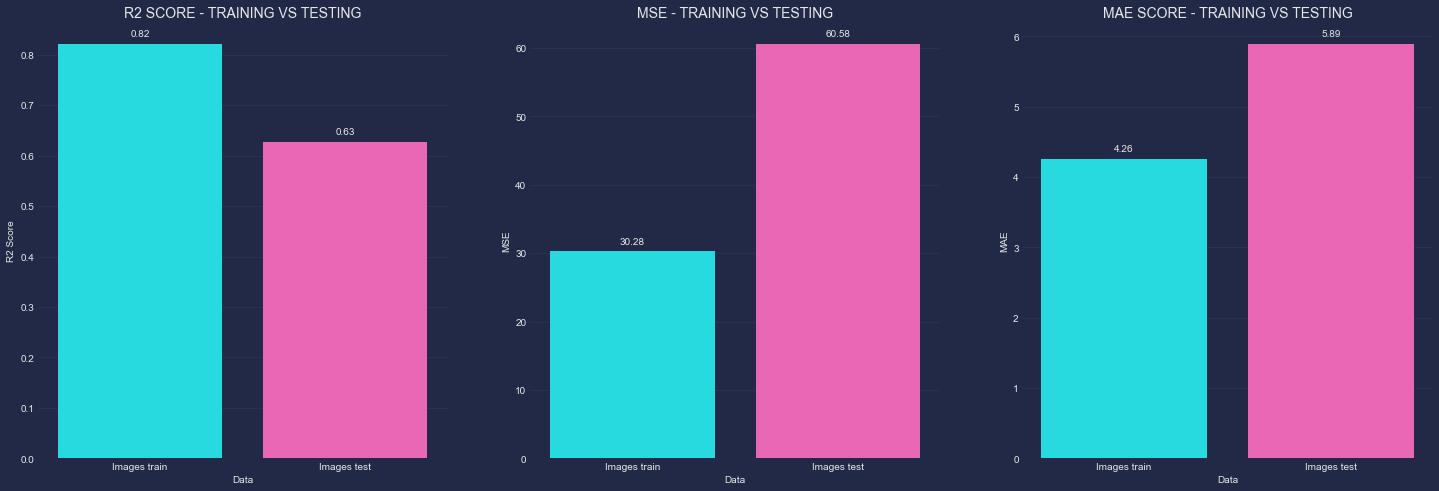

In [12]:
plt.style.use('cyberpunk')

fig, axes = plt.subplots(1, 3, figsize = (25, 8))

sns.barplot(x = 'Data', y = 'R2 Score', data = imagesResults, ax = axes[0])
sns.barplot(x = 'Data', y = 'MSE', data = imagesResults, ax = axes[1])
sns.barplot(x = 'Data', y = 'MAE', data = imagesResults, ax = axes[2])

axes[0].set_title('R2 SCORE - TRAINING VS TESTING', fontsize = 14)
axes[1].set_title('MSE - TRAINING VS TESTING', fontsize = 14)
axes[2].set_title('MAE SCORE - TRAINING VS TESTING', fontsize = 14)

for patch in axes[0].patches:
    axes[0].annotate(format(patch.get_height(), '.2f'), (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

for patch in axes[1].patches:
    axes[1].annotate(format(patch.get_height(), '.2f'), (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

for patch in axes[2].patches:
    axes[2].annotate(format(patch.get_height(), '.2f'), (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

mplcyberpunk.add_glow_effects()

plt.show()

## EXPORTING THE NEURAL NETWORK USING THE PICKLE LIBRARY

In [13]:
ageClassifier.save("../models/ageFull.h5")